In [26]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
from tensorflow import keras
import numpy as np
import scipy.optimize as sopt
import time
import scipy.io
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import os

In [27]:
np.random.seed(1234)
tf.random.set_seed(1234)

In [28]:
class PINN:
    def __init__(self, x, y, t, u, v, layers):
        
        X = np.concatenate([x, y, t], 1)
        
        self.lb = X.min(0)
        self.ub = X.max(0)
                
        self.X = X
        
        self.x = X[:,0:1]
        self.y = X[:,1:2]
        self.t = X[:,2:3]
        
        self.u = u
        self.v = v
        
        self.layers = layers
        
        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)        
        
        # Initialize parameters
        self.lambda_1 = tf.Variable([0.0], dtype=tf.float32)
        self.lambda_2 = tf.Variable([0.0], dtype=tf.float32)
        
        # tf placeholders and graph
        self.sess = tf.compat.v1.Session()
        
        self.x_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.y_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.y.shape[1]])
        self.t_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        
        self.u_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        self.v_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.v.shape[1]])
        
        self.u_pred, self.v_pred, self.p_pred, self.f_u_pred, self.f_v_pred = self.net_NS(self.x_tf, self.y_tf, self.t_tf)
        
        self.loss = tf.reduce_sum(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_sum(tf.square(self.v_tf - self.v_pred)) + \
                    tf.reduce_sum(tf.square(self.f_u_pred)) + \
                    tf.reduce_sum(tf.square(self.f_v_pred))
        
        self.adam = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-3)
        self.train_op_adam = self.adam.minimize(self.loss)
        
        init = tf.compat.v1.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
        
    def net_NS(self, x, y, t):
        lambda_1 = self.lambda_1
        lambda_2 = self.lambda_2
        
        psi_and_p = self.neural_net(tf.concat([x,y,t], 1), self.weights, self.biases)
        psi = psi_and_p[:,0:1]
        p = psi_and_p[:,1:2]
        
        u = tf.gradients(psi, y)[0]
        v = -tf.gradients(psi, x)[0]  
        
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_y = tf.gradients(u, y)[0]
        u_xx = tf.gradients(u_x, x)[0]
        u_yy = tf.gradients(u_y, y)[0]
        
        v_t = tf.gradients(v, t)[0]
        v_x = tf.gradients(v, x)[0]
        v_y = tf.gradients(v, y)[0]
        v_xx = tf.gradients(v_x, x)[0]
        v_yy = tf.gradients(v_y, y)[0]
        
        p_x = tf.gradients(p, x)[0]
        p_y = tf.gradients(p, y)[0]

        f_u = u_t + lambda_1*(u*u_x + v*u_y) + p_x - lambda_2*(u_xx + u_yy) 
        f_v = v_t + lambda_1*(u*v_x + v*v_y) + p_y - lambda_2*(v_xx + v_yy)
        
        return u, v, p, f_u, f_v
    
    def callback(self, loss, lambda_1, lambda_2):
        print('Loss: %.3e, l1: %.3f, l2: %.5f' % (loss, lambda_1, lambda_2))
      
    def train(self, nIter): 

        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t,
                   self.u_tf: self.u, self.v_tf: self.v}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                lambda_1_value = self.sess.run(self.lambda_1)
                lambda_2_value = self.sess.run(self.lambda_2)
                print('It: %d, Loss: %.3e, l1: %.3f, l2: %.5f, Time: %.2f' % 
                      (it, loss_value, lambda_1_value, lambda_2_value, elapsed))
                start_time = time.time()
            
            
    
    def predict(self, x_star, y_star, t_star):
        
        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}
        
        u_star = self.sess.run(self.u_pred, tf_dict)
        v_star = self.sess.run(self.v_pred, tf_dict)
        p_star = self.sess.run(self.p_pred, tf_dict)
        
        return u_star, v_star, p_star

In [29]:
def plot_solution(x_gt, y_gt, u_star, index):
    X_star = np.concatenate([x_gt, y_gt], 1)    
    lb = X_star.min(0)
    ub = X_star.max(0)
    nn = 200
    x = np.linspace(lb[0], ub[0], nn)
    y = np.linspace(lb[1], ub[1], nn)
    X, Y = np.meshgrid(x,y)
    
    U_star = griddata(X_star, u_star.flatten(), (X, Y), method='cubic')
    
    plt.figure(index)
    plt.pcolor(X,Y,U_star, cmap = 'jet')
    plt.colorbar()
    
    
def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/4
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

In [30]:
if __name__ == "__main__":
    N_train = 5000

    layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2]
    
    data = scipy.io.loadmat('reference_solution.mat')
    U_gt = data['uref']
    V_gt = data['vref'] 
    t_gt = data['t']
    x_gt = np.tile(data['x'], 101).T
    y_gt = np.tile(data['y'].T, 101).flatten()[None, :].T
    u_gt = U_gt.reshape(10201, 101)
    v_gt = V_gt.reshape(10201, 101)

    N = x_gt.shape[0]
    T = t_gt.shape[1]

    xx = np.tile(x_gt, (1, T))
    yy = np.tile(y_gt, (1, T))
    tt = np.tile(t_gt, (N, 1))

    x_f = xx.flatten()[:,None]
    y_f = yy.flatten()[:,None]
    t_f = tt.flatten()[:,None]

    u_f = U_gt.flatten()[:,None]
    v_f = V_gt.flatten()[:,None]

    idx = np.random.choice(N*T, N_train, replace=False)
    x_train = x_f[idx,:]
    y_train = y_f[idx,:]
    t_train = t_f[idx,:]
    u_train = u_f[idx,:]
    v_train = v_f[idx,:]


In [ ]:
model = PINN(x_train, y_train, t_train, u_train, v_train, layers)
model.train(100000)

In [45]:
# Test Data
snap = np.array([100])
x_star = x_gt
y_star = y_gt
t_star = tt[:, snap]
    
u_star = u_gt[:, snap]
v_star = v_gt[:, snap]
print(t_star)


[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [46]:
# Prediction
u_pred, v_pred, p_pred = model.predict(x_star, y_star, t_star)
lambda_1_value = model.sess.run(model.lambda_1)
lambda_2_value = model.sess.run(model.lambda_2)

Error u: 8.399540e-01
Error v: 3.174537e-01
Error l1: 24.49186%
Error l2: 282.06549%


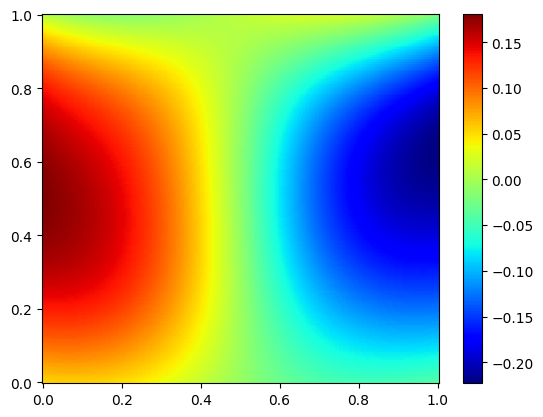

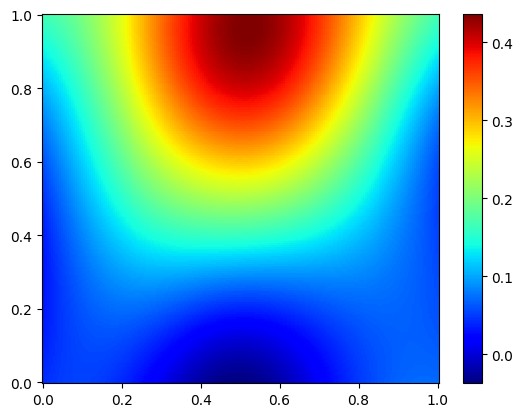

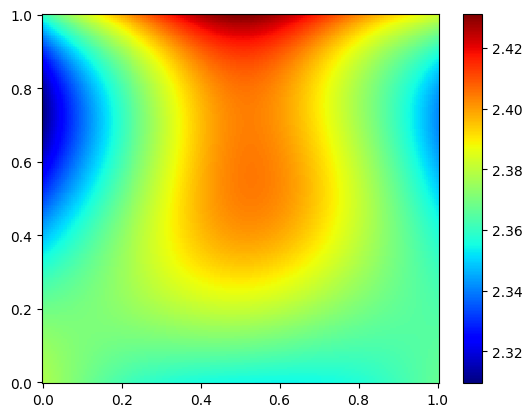

In [47]:
# Error
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)

error_lambda_1 = np.abs(lambda_1_value - 1.0)*100
error_lambda_2 = np.abs(lambda_2_value - 0.01)/0.01 * 100
    
print('Error u: %e' % (error_u))    
print('Error v: %e' % (error_v))     
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2))                  
X_star = np.concatenate([x_gt, y_gt], 1)    
    # Plot Results
plot_solution(x_gt, y_gt, u_pred, 1)
plot_solution(x_gt, y_gt, v_pred, 2)
plot_solution(x_gt, y_gt, p_pred, 3)    
    
    # Predict for plotting

lb = X_star.min(0)
ub = X_star.max(0)
nn = 200
x = np.linspace(lb[0], ub[0], nn)
y = np.linspace(lb[1], ub[1], nn)
X, Y = np.meshgrid(x,y)
    
UU_star = griddata(X_star, u_pred.flatten(), (X, Y), method='cubic')
VV_star = griddata(X_star, v_pred.flatten(), (X, Y), method='cubic')